In [1]:
%load_ext autoreload

%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorboardX import SummaryWriter

import gc
from pathlib import Path


from sklearn.metrics import accuracy_score
from IPython.display import FileLink

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

import torchvision.transforms as transforms
import torch
from torch import autograd
import torch.nn as nn
import torch.nn.functional as F
#from models.gatedconv import InpaintGCNet, InpaintDirciminator
from models.unet_fastai_resblock import InpaintSANet, InpaintSADirciminator
from models.loss import SNDisLoss, SNGenLoss, ReconLoss, NewLoss

from util.logger import TensorBoardLogger
from util.config import Config
from data.fastai_dataset import InpaintDataset
from util.evaluation import AverageMeter
from evaluation import metrics
from PIL import Image
import pickle as pkl
import numpy as np
import logging
import time
import sys
import os


In [2]:

config = Config('config/inpaint_places2_sagan.yml')
logger = logging.getLogger(__name__)
time_stamp = time.strftime('%Y%m%d%H%M', time.localtime(time.time()))
log_dir = 'model_logs/{}_{}'.format(time_stamp, config.LOG_DIR)
result_dir = 'result_logs/{}_{}'.format(time_stamp, config.LOG_DIR)
tensorboardlogger = TensorBoardLogger(log_dir)
cuda0 = torch.device('cuda:{}'.format(config.GPU_ID))
cpu0 = torch.device('cpu')

def logger_init():
    """
    Initialize the logger to some file.
    """
    logging.basicConfig(level=logging.INFO)

    logfile = 'logs/{}_{}.log'.format(time_stamp, config.LOG_DIR)
    fh = logging.FileHandler(logfile, mode='w')
    formatter = logging.Formatter("%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

In [6]:
    logger_init()
    dataset_type = config.DATASET
    batch_size = config.BATCH_SIZE
train_dataset = InpaintDataset(config.DATA_FLIST[dataset_type][0],\
                                      {mask_type:config.DATA_FLIST[config.MASKDATASET][mask_type][0] for mask_type in config.MASK_TYPES}, \
                                      resize_shape=tuple(config.IMG_SHAPES), random_bbox_shape=config.RANDOM_BBOX_SHAPE, \
                                      random_bbox_margin=config.RANDOM_BBOX_MARGIN,
                                      random_ff_setting=config.RANDOM_FF_SETTING)
val_dataset = InpaintDataset(config.DATA_FLIST[dataset_type][1],\
                                    {mask_type:config.DATA_FLIST[config.MASKDATASET][mask_type][1] for mask_type in ('val',)}, \
                                    resize_shape=tuple(config.IMG_SHAPES), random_bbox_shape=config.RANDOM_BBOX_SHAPE, \
                                    random_bbox_margin=config.RANDOM_BBOX_MARGIN,
                                    random_ff_setting=config.RANDOM_FF_SETTING,val=True)

{'mine': '/home/xudejia/inpainting/data/train_mask_list.txt'}
{'val': '/home/xudejia/inpainting/data/val_mask_list.txt'}


In [7]:
# input()

In [8]:
db = DataBunch.create(train_ds=train_dataset, valid_ds=val_dataset, bs=8, val_bs=8,num_workers=16, pin_memory=True)
logger.info("Finish the dataset initialization.")

INFO:__main__:Finish the dataset initialization.


In [9]:
"""
cnt = 0
for w in db.train_ds:
    cnt = cnt + 1
    print('?', len(w))
    print(len(w[0]))
    for x in w[0]:
        print(x)
    if (cnt > 2):
        
        break
print(cnt)
"""

"\ncnt = 0\nfor w in db.train_ds:\n    cnt = cnt + 1\n    print('?', len(w))\n    print(len(w[0]))\n    for x in w[0]:\n        print(x)\n    if (cnt > 2):\n        \n        break\nprint(cnt)\n"

In [10]:
logger.info("Define the Network Structure and Losses")
netG = InpaintSANet()
# netD = InpaintSADirciminator()
"""
if config.MODEL_RESTORE != '':
        whole_model_path = 'model_logs/{}'.format( config.MODEL_RESTORE)
        nets = torch.load(whole_model_path)
        netG_state_dict, netD_state_dict = nets['netG_state_dict'], nets['netD_state_dict']
        netG.load_state_dict(netG_state_dict)
        netD.load_state_dict(netD_state_dict)
        logger.info("Loading pretrained models from {} ...".format(config.MODEL_RESTORE))
"""

INFO:__main__:Define the Network Structure and Losses


'\nif config.MODEL_RESTORE != \'\':\n        whole_model_path = \'model_logs/{}\'.format( config.MODEL_RESTORE)\n        nets = torch.load(whole_model_path)\n        netG_state_dict, netD_state_dict = nets[\'netG_state_dict\'], nets[\'netD_state_dict\']\n        netG.load_state_dict(netG_state_dict)\n        netD.load_state_dict(netD_state_dict)\n        logger.info("Loading pretrained models from {} ...".format(config.MODEL_RESTORE))\n'

In [11]:
RLoss = ReconLoss(*(config.L1_LOSS_ALPHA))
GLoss = SNGenLoss(config.GAN_LOSS_ALPHA)
DLoss = SNDisLoss()
NLoss = NewLoss()

In [12]:
# SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')

In [13]:
def MyLoss(out, img, masks):
    """
    print(len(out))
    print(len(target))
    print(len(ww))
    for x in out:
        print(x.shape)
    for x in target:
        print(x.shape)
    for x in ww:
        print(x.shape)
    """
    coarse_imgs, refined, mixed = out
    # img, masks = target
    complete_imgs = mixed
    r_loss = RLoss(img, coarse_imgs, mixed, masks)
    n_loss = NLoss(coarse_imgs, refined, mixed, img)
    return r_loss + n_loss

In [14]:
def img2photo(imgs):
    # torch.Size([3, 256, 256])
    # return ((imgs+1)*127.5).detach().cpu().numpy()
    return ((imgs+1)/2).detach().cpu()
    # return ((imgs+1)*127.5).transpose(0, 1).transpose(1, 2).detach().cpu().numpy().astype(np.uint8)
    # return ((imgs+1)*127.5).transpose(1,2).transpose(2,3).detach().cpu().numpy()
class TensorboardLogger(Callback):
    """
    A general Purpose Logger for TensorboardX
    Also save a .txt file for the important parts
    """

    def __init__(self, learner, log_name, cfgtxt, del_existing=False, histogram_freq=100):
        """
        Learner is the ConvLearner
        log_name: name of the log directory to be formed. Will be input
        for each run
        cfgtxt: HyperParams
        del_existing: To run the experiment from scratch and remove previous logs
        """
        super().__init__()
        self.learn = learner
        self.model = learner.model
        self.md = learner.data

        self.metrics_names = ["validation_loss"]
        self.metrics_names += [m.__name__ for m in learner.metrics]

        self.best_met = 0

        self.histogram_freq = histogram_freq
        self.cfgtxt = cfgtxt

        path = Path(self.md.path) / "model_logs"
        self.log_name = log_name
        self.log_dir = path / log_name

        self.init_logs(self.log_dir, del_existing)
        self.init_tb_writer()
        self.init_txt_writer(path, log_name)

    def init_logs(self, log_dir, del_existing):
        if log_dir.exists():
            if del_existing:
                print(f'removing existing log with same name {log_dir.stem}')
                shutil.rmtree(self.log_dir)

    def init_tb_writer(self):
        self.writer = SummaryWriter(
            comment='main_mdl', log_dir=str(self.log_dir))
        self.writer.add_text('HyperParams', self.cfgtxt)

    def init_txt_writer(self, path, log_name):
        self.fw_ = path / f'{log_name}.txt'
        self.str_form = '{} \t {} \t '
        for m in self.metrics_names:
            self.str_form += '{} \t '
        self.str_form += '\n'
        self.out_str = self.str_form.format(
            'epoch', 'trn_loss', *self.metrics_names)

        with open(self.fw_, 'w') as f:
            f.write(self.cfgtxt)
            f.write('\n')
            f.write(self.out_str)

    def on_batch_end(self, **kwargs):
        self.trn_loss = kwargs['last_loss']
        num_batch = kwargs['num_batch']
        self.writer.add_scalar(
            'trn_loss_batch', self.trn_loss, num_batch)
        last_output = kwargs['last_output']
        last_target = kwargs['last_target']
        epoch = kwargs['epoch']
        iteration = kwargs['iteration']
        if iteration % 5 == 0:
            """
            print(len(last_target[0]))
            for x in last_target[0]:
                print(x.shape)
            """
            imgs, masks = last_target[0][0].detach(), last_target[1][0].detach()
            coarse_imgs, refined, complete_imgs = last_output[0][0].detach(), last_output[1][0].detach(), last_output[2][0].detach()
            # torch.Size([3, 256, 256])
            img = img2photo(torch.cat([imgs * (1 - masks) + masks, refined, imgs * masks, complete_imgs, imgs], dim=2))
            self.writer.add_image('train/whole_imgs%d'%epoch, img, iteration)
    def on_epoch_end(self, **kwargs):
        metrics = kwargs['last_metrics']
        epoch = kwargs['epoch']
        trn_loss = kwargs['smooth_loss']
        self.writer.add_scalar('trn_loss', trn_loss, epoch)

        for val, name in zip(metrics, self.metrics_names):
            self.writer.add_scalar(name, val, epoch)

        self.file_write(self.str_form.format(epoch,
                                             self.trn_loss, *metrics))

        m = metrics[1]
        if m > self.best_met:
            self.best_met = m
            self.learn.save(self.log_name)

    def on_train_end(self, **kwargs):
        self.writer.add_text('Total Epochs', str(kwargs['epoch']))
        self.writer.close()
        self.file_write(f'Epochs done, {kwargs["epoch"]}')

    def file_write(self, outstr):
        with open(self.fw_, 'a') as f:
            f.write(outstr)

In [15]:
# learn.destroy()

In [16]:
class PSNR(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self):
        # If it's a partial, use func.func
        # name = getattr(func,'func',func).__name__
        self.name = 'PSNR'
        self.__name__ = 'PSNR'
        self.func = metrics['ppsnr']
        # self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, **kwargs):
        with torch.no_grad():
            ww = kwargs['last_output']
            aa = kwargs['last_target']
            last_output = ww[-1]
            last_target = aa[0]
            "Update metric computation with `last_output` and `last_target`."
            if not is_listy(last_target): last_target=[last_target]
            self.count += last_target[0].size(0)
            """
            print(len(last_output))
            for x in last_output:
                print(x.shape)
            """
            # val = self.func(last_output, *last_target)
            val = self.func(*last_target, last_output)
            self.val += last_target[0].size(0) * val

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)
class SSIM(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self):
        # If it's a partial, use func.func
        # name = getattr(func,'func',func).__name__
        self.name = 'SSIM'
        self.__name__ = 'SSIM'
        self.func = metrics['sssim']
        # self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, **kwargs):
        with torch.no_grad():
            ww = kwargs['last_output']
            aa = kwargs['last_target']
            last_output = ww[-1]
            last_target = aa[0]
            # last_output = last_output[0]
            "Update metric computation with `last_output` and `last_target`."
            if not is_listy(last_target): last_target=[last_target]
            self.count += last_target[0].size(0)
            # val = self.func(last_output, *last_target)
            val = self.func(*last_target, last_output)
            self.val += last_target[0].size(0) * val
        # self.val += last_target[0].size(0) * val.detach().cpu()

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)
psnr = PSNR()
ssim = SSIM()

In [37]:
lr, decay = config.LEARNING_RATE, config.WEIGHT_DECAY
learn = Learner(db, netG, loss_func=MyLoss, metrics=[psnr, ssim], callback_fns=[partial(EarlyStoppingCallback, monitor='PSNR', min_delta=0.01, patience=20)], model_dir='./weights')

In [18]:
# learn.validate()
# [6.939414, 9.518688486670799, tensor(0.2730, device='cuda:0')]
# loss, psnr, ssim?

In [19]:
# learn.validate()

/home/xudejia/anaconda2/envs/py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xudejia/anaconda2/envs/py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/xudejia/anaconda2/envs/py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


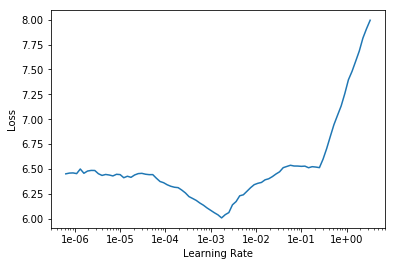

In [20]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.validate()

[6.344649, 11.04979870679206, tensor(0.3148, device='cuda:0')]

In [38]:
learn.load('best')

Learner(data=DataBunch;

Train: <data.fastai_dataset.InpaintDataset object at 0x7fd68bba06a0>;

Valid: <data.fastai_dataset.InpaintDataset object at 0x7fd68bba0940>;

Test: None, model=InpaintSANet(
  (coarse_net): Sequential(
    (0): GatedConv2dWithActivation(
      (activation): LeakyReLU(negative_slope=0.2, inplace)
      (conv2d): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (mask_conv2d): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (batch_norm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sigmoid): Sigmoid()
    )
    (1): GatedConv2dWithActivation(
      (activation): LeakyReLU(negative_slope=0.2, inplace)
      (conv2d): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (mask_conv2d): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (batch_norm2d): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sig

In [33]:
learn.validate()

[1.7882265, 22.062362118367478, tensor(0.8821, device='cuda:0')]

In [ ]:
# learn.fit_one_cycle(1, lr=1e-2, callback_fns=[SaveModelCallback(learn, every='improvement', monitor='psnr', name='best'), TensorboardLogger(learn, "fastai-1")])

In [ ]:
# learn.recorder.plot()

/home/xudejia/anaconda2/envs/py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xudejia/anaconda2/envs/py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/xudejia/anaconda2/envs/py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


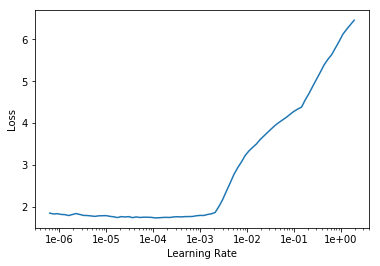

In [35]:
learn.lr_find()
learn.recorder.plot()

In [39]:
# lr = (1e-2)/2
# 可能是 lr 变大之后才炸的..
lr = 1e-4
NAME = "fastai-unet-swish-part2" # with new val
learn.fit_one_cycle(50, max_lr=slice(lr), callbacks=[SaveModelCallback(learn, every='improvement', monitor='PSNR', name='best'), TensorboardLogger(learn, NAME, cfgtxt=str(lr))])

epoch,train_loss,valid_loss,PSNR,SSIM,time
0,1.742574,1.799257,21.945085,0.880920,13:22
1,1.709681,1.808021,21.924871,0.880425,13:23
2,1.737892,1.792269,22.008202,0.881185,13:23
3,1.747863,1.817282,21.863152,0.880541,13:21
4,1.743193,1.799664,21.947959,0.880707,13:23
5,1.744336,1.793547,21.903100,0.881007,13:23
6,1.744633,1.811060,21.876106,0.880844,13:23
7,1.762779,1.762734,21.996607,0.882469,13:23
8,1.706433,1.793206,22.043824,0.881723,13:25
9,1.738010,1.805140,21.865815,0.879977,13:25


/home/xudejia/anaconda2/envs/py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/xudejia/anaconda2/envs/py3.6/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/xudejia/anaconda2/envs/py3.6/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Better model found at epoch 0 with PSNR value: 21.945084679186504.
Better model found at epoch 2 with PSNR value: 22.008201978640315.
Better model found at epoch 8 with PSNR value: 22.043824005045153.
Epoch 29: early stopping
